# Bayesian Optimization with EnergyPlus

This notebook presents an example of optimizing an EnergyPlus model using Bayesian optimization. It requires the Eppy and Bayesian Optimization packages. It uses an example file included in the EnergyPluss v22.2 download that adjusts the window opening position based on the relative humidity (RH) through EMS. In this example, we optimize the RH threshold for opening and closing the window to minimize site energy for the month of September. It is intended to be an example for future EnergyPlus applications with Bayesian optimization, which is particularly useful when the objective is expensive to evaluate like in this case.

### Install packages
1. Download EnergyPlus v22.2: https://github.com/NREL/EnergyPlus/releases/tag/v22.2.0
2. Install Bayesian Optimization: https://github.com/bayesian-optimization/BayesianOptimization
3. Install Eppy: https://pypi.org/project/eppy/

In [3]:
# Import packages
from bayes_opt import BayesianOptimization
from scipy.optimize import NonlinearConstraint
from eppy.modeleditor import IDF
from eppy.results import readhtml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Set paths
Assuming EnergyPlus v22.2 is installed, the only path that needs to be changed is the output_file_path, which should be the same location as this notebook. If implementing your own example, change the idf_file_path and the epw_file_path as well.

In [6]:
# Set paths
idd_file_path = r'C:\EnergyPlusV22-2-0\Energy+.idd'
idf_file_path = r'C:\EnergyPlusV22-2-0\ExampleFiles\EMSAirflowNetworkOpeningControlByHumidity.idf'
epw_file_path = r'C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw'
output_file_path = r'C:\eplus_opt'  # TODO: Change based on your setup

### Modify example file
For this example, we are using one of the EMS examples provided by EnergyPlus. However, we first need to modify:
1. The run period (to reduce the simulation time for example purposes)
2. The simulation controls so we can calculate site energy

In [7]:
# Modify IDF file from EnergyPlus download

# Load the IDF file
IDF.setiddname(idd_file_path)
idf = IDF(idf_file_path)

# Access the RunPeriod object
run_period = idf.idfobjects['RUNPERIOD'][0]

# Modify the start and end dates
run_period.Begin_Month = 9
run_period.Begin_Day_of_Month = 1
run_period.End_Month = 9
run_period.End_Day_of_Month = 30

# Access the SimulationControl object
simulation_control = idf.idfobjects['SIMULATIONCONTROL'][0]

# Modify simulation control parameters
simulation_control.Do_Zone_Sizing_Calculation = 'Yes'
simulation_control.Do_System_Sizing_Calculation = 'Yes'
simulation_control.Do_Plant_Sizing_Calculation = 'Yes'
simulation_control.Run_Simulation_for_Sizing_Periods = 'No'
simulation_control.Run_Simulation_for_Weather_File_Run_Periods = 'Yes'

# Save the modified IDF file
mod_idf_file_path = output_file_path + '\modified_inputfile.idf'
idf.saveas(mod_idf_file_path)

### Define objective function

We need to define the objective function, which in this case is an output from the EnergyPlus simulation. The arguments should be the variables we want to optimize. Lines 10-14 modify the EMS program using Eppy. For other applications, refer to the Eppy documentation. Lastly, we retrive the site energy using Eppy's readhtml function.

In [8]:
# Define objective function using Eppy
# This function should only pass the variables for optimization
def energy_obj(RH_open, RH_close):
    
    # Retrive idf file
    IDF.setiddname(idd_file_path)
    idf = IDF(mod_idf_file_path, epw_file_path)

    # Modify the EMS program
    for program in idf.idfobjects['ENERGYMANAGEMENTSYSTEM:PROGRAM']:
        if program.Name == 'RH_OpeningController':
            program.Program_Line_1 = f'IF ZoneRH < {RH_open}'
            program.Program_Line_3 = f'ELSEIF ZoneRH > {RH_close}'
            program.Program_Line_6 = f'SET MyOpenFactor = (ZoneRH - {RH_open}) / ({RH_close} - {RH_open})'
    
    # Run the EnergyPlus simulation
    idf.run(output_directory=output_file_path)

    # Retrieve and return the performance metric of interest
    table_file_path = output_file_path + '\eplustbl.htm'
    file_handle = open(table_file_path, 'r').read()
    output_tables = readhtml.titletable(file_handle)
    performance_metric = -float(output_tables[0][1][2][1]) # Make negative because the algorithm maximizes objective

    return performance_metric

### Define constraints

If there are any constraints in your problem, define them using the SciPy NonlinearConstraint function. 

In [10]:
# Define constraints
# If multiple constraints, return a numpy array
def constraint_function(RH_open, RH_close):
    return RH_close - RH_open  # RH_close - RH_open >= 0

In [11]:
# Define upper and lower bounds for the constraint
constraint_lower = 0
constraint_upper = np.inf  # Since is is a one-sided constraint

In [12]:
# Register constraint(s)
# If multiple constraints, inputs should be numpy arrays
constraint = NonlinearConstraint(constraint_function, constraint_lower, constraint_upper)

### Set up optimizer and run

Set the bounds for each variable in the optimization problem. Set a random seed for reproducibility. 

In [17]:
# Set up the BayesianOptimization object with constraints
optimizer = BayesianOptimization(
    f=energy_obj,
    constraint=constraint,
    pbounds={'RH_open':(5, 95),  # Set variable bounds
             'RH_close':(5, 95),
             },
    verbose=2,
    random_state=42,  # Set a random seed for reproducibility
)

In [18]:
# Optimize with constraints
# The total number of simulations = number of initial points + number of iterations
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   |  allowed  | RH_close  |  RH_open  |
-------------------------------------------------------------

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 1         | -12.67    | False     | 38.71     | 90.56     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 2         | -12.7     | True      | 70.88     | 58.88     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\lau

| 23        | -12.95    | True      | 64.95     | 43.49     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 24        | -12.81    | True      | 95.0      | 38.22     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 25        | -12.67    | True      | 88.76     | 77.64     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 26        | -13.03    | True 

| 46        | -12.66    | True      | 79.46     | 71.91     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 47        | -12.67    | True      | 95.0      | 59.06     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 48        | -12.67    | True      | 95.0      | 57.29     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 49        | -12.67    | True 

| 69        | -12.67    | True      | 85.95     | 73.89     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 70        | -12.67    | True      | 91.91     | 79.85     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 71        | -12.67    | True      | 92.02     | 87.84     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 72        | -12.67    | True 

| 92        | -12.84    | True      | 95.0      | 30.74     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 93        | -12.66    | True      | 77.49     | 73.4      |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 94        | -12.66    | True      | 95.0      | 66.43     |

C:\EnergyPlusV22-2-0\energyplus.exe --weather C:\EnergyPlusV22-2-0\WeatherData\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw --output-directory C:\Users\laura\Documents\eplus_opt --idd C:\EnergyPlusV22-2-0\Energy+.idd C:\Users\laura\Documents\eplus_opt\in.idf

| 95        | -12.66    | True 

### Process results

In [19]:
# Access the best parameters and corresponding objective value
best_params = optimizer.max['params']
best_objective_value = optimizer.max['target']
print(f'The best objective value is: {best_objective_value}')
print(f'The best parameters are: {best_params}')

The best objective value is: -12.66
The best parameters are: {'RH_close': 87.14659810500778, 'RH_open': 69.17949147847544}


Now we have the best objective value and corresponding parameters. All the information from the optimization was stored and can be retrieved and plotted.

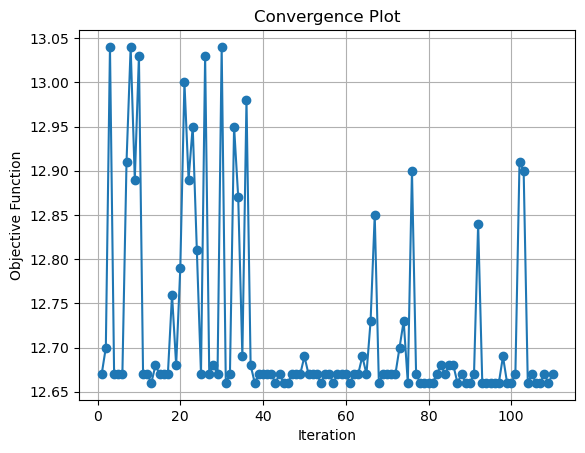

In [21]:
# Extract values associated with the key 'y'
y_values = [abs(d['target']) for d in optimizer.res]

# Generate x values (assuming sequential integers for this example)
x_values = list(range(1, len(optimizer.res) + 1))

# Plotting
plt.plot(x_values, y_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()